Plotting a filament with noise added.  Load in the SB data file then pick exposure time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def plotfilament(SBdata,ax,colmap='viridis',onlyyellow=False,contours=True,mockobs=False,labelaxes=False):
    # setting up the plot
    if mockobs:
        clabel = r'log signal (photons)'
    else:
        clabel = r'log photons/cm$^2$/s/sr'
    Vmin = None
    Vmax= None
    #fig = plt.figure(figsize = (7.5, 8.))
    #ax = plt.subplot(121)
    fontsize=13

    if labelaxes:
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        #xlabels = [0,0.6,1.2,1.8,2.4,3.0]
        #ax.set_xticks([0,5,10,15,20,25], minor=False)
        #ax.set_xticklabels(xlabels, minor=False)
        #ylabels = [ 0.,0.25,0.5]
        #ax.set_yticks([0,2.5,5], minor=False)
        #ax.set_yticklabels(ylabels, minor=False)
    
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
        ax.xaxis.set_label_position('top') 
        ax.xaxis.tick_top()
        
    
    #colmap = 'viridis'#'gist_gray'#'plasma'#'viridis' #'afmhot'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value

    
    ## If you only want to plot the SB greater than 1 photon/s/cm^2/arcsec^2 then do the following
    if onlyyellow:
        SBonlyyellow = SBdata
        SBonlyyellow[SBdata<0.] = -3.
        img = ax.imshow(SBonlyyellow.T,origin='lower', cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')
        levels = [0,1,2]
        colours = ['yellow','cyan','purple']
    else:
        img = ax.imshow(SBdata.T,origin='lower',extent=(0,3.7,0,0.7), cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')
        levels = np.array([-2,-1,0,1,2,3])
        colours = ('red','orange','yellow','cyan','purple','pink')
        #levels = np.array([-2,-1.5,-1,-0.5,0,0.3,1,1.5,2,2.5,3])
        #colours = ('red','black','orange','black','yellow','black','cyan','black','purple','black','pink')
    
    # plot contours
    cmap = cm.PRGn
    if contours:
        ax.contour(SBdata.T,levels,colors=colours)#,cmap=cm.get_cmap(cmap, len(levels) - 1),)

    div = axgrid.make_axes_locatable(ax)
    #cax = div.append_axes("bottom",size="15%",pad=0.1)
    #cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
    #cbar.solids.set_edgecolor("face")
    #cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
    ##cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
    #cbar.ax.tick_params(labelsize=fontsize)


In [3]:
def addnoise(data,resolution,exptime=10**3*3600.,CMOS=False):
    # Dragonfly info
    area_lens = np.pi*(14.3/2)**2 * 48.                 # cm^2, 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                      # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2      # rad^2, the pixel size of the CCD
    tau_l = 0.85                                        # transmittance of the Dragonfly lens
    tau_f = 1.                                          # transmittance of the Halpha filter -- assumed for now
    #B = getBackground(656.3,657.3,machine)              # *u.photon/u.second/u.arcsec**2/u.m**2  ****already multiplied by the bandwidth***
    B = 0.560633
    D = 0.04       # dark current (electrons / s) 
    
    if CMOS:
   #     print "Using new CMOS cameras..."
        QE = 0.70                                       # quantum efficiency of the CMOS detector
        R_squared = 2.**2                               # read noise (electrons)
    else:
   #     print "Using old cameras..."
        QE = 0.48                                       # quantum efficiency of the CCDs
        R_squared = 10.**2                              # read noise (electrons)
    
   # R_squared = 50.**2
    
    binpix_size = resolution # arcsec
    numpixel = round((binpix_size/pix_size)**2)
    #print "the number of pixels is %s"%numpixel
    
    
    ### total signal incident in exposure time ###
    totsignal = 10**data * exptime # ( photons / cm^2 /sr )
    ### total signal detected (accounting for system efficiency) ###
    detsignal = totsignal * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    #print "the total object signal [electrons] detected ranges from: %s to %s"%(np.min(detsignal),np.max(detsignal))
    #print "an example of the object signal [electrons] is: %s"%detsignal[0]


    ### Background from stuff in space ###
    'background sky signal detected [B]=ph/s/arcsec^2/m^2, [B_sky]=ph/s (in a pixel)'
    B_sky = B * QE * tau_l * tau_f * area_lens*(1/100.)**2 * pix_size**2
    #print "the background in the bandwidth is: %s"%B
    #print "the background signal, B_sky [ph/s (in a pixel)], is: %s"%B_sky
    B_sky_inexptime = B_sky*exptime
    B_sky_total     = B_sky*exptime*numpixel    
    B_sky_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            B_sky_array[x][y]=np.random.normal(0,np.sqrt(B_sky_total+detsignal[x][y])) 
#            B_sky_array[x][y]=np.random.poisson(B_sky_total)
    B_sky_array_total = B_sky_array
    #print "the mean total background signal, B_sky_total [electrons], is: %s"%B_sky_total
    #print "the total background noisy signal [electrons] ranges from: %s to %s"%(np.min(B_sky_array_total),np.max(B_sky_array_total))
    
    # Signal
    noiseadded_signal = detsignal + B_sky_total + B_sky_array
    
    ### ReadOutNoise ###
    numexposures = exptime/3600. # hour long exposures
    R_squared_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            R_squared_array[x][y]=np.mean(np.random.normal(np.sqrt(R_squared),np.sqrt(np.sqrt(B_sky)),int(numpixel)))**2   
    R_squared_total = R_squared * round(numexposures)
    R_squared_total_array = R_squared_array * round(numexposures)
    #print "the R_squared value is: %s, so in %s exposures [per pixel], will have R_squared of: %s, %s"%(R_squared,numexposures,R_squared_total,R_squared_total_array[0])
    #print "the total R_squared value [electrons] multiplying by numpix read out is: %s, %s"%((R_squared_total*numpixel),(R_squared_total_array[0]*numpixel))
    
    ### DarkCurrent ###
    noise_from_detector = 0.0
    #D_total = D*exptime*numpixel
    #D_array = np.zeros((data.shape[0],data.shape[1]))
    #for x in range(data.shape[0]):
    #    for y in range(data.shape[1]):
    #        D_array[x][y]=np.random.normal(D_total,np.sqrt(D_total)) 
    #D_array_total = D_array
    #print "the total dark current [electrons] is: %s , %s"%(D_total, D_array_total[0])

    #noise_from_detector = D_array_total + R_squared_total_array*numpixel
    #print "an example total noise (not squarerooted) is: %s"%(detsignal + B_sky_array_total + D_array_total + R_squared_total_array*numpixel)[0]
    #print "an example total noise (squarerooted) is: %s"%sigma[0]
    
    
    # Now add noise from the detector
    
    noiseadded_signal = noiseadded_signal + noise_from_detector
    
    return noiseadded_signal


Load the EAGLE SB data from a saved file:

In [5]:
resolution = 500. #arcsec
SBdata = np.load('SBdata_500arcsec.npz')['arr_0']

In [6]:
SBdata.shape

(30, 7)

In [7]:
def plotit(exptime, mymap='gist_gray'):
    
    addnoisesqrt = False

    #  Add the noise to the EAGLE SB data
    SBdata_exp0 = addnoise(SBdata,resolution,exptime=exptime,CMOS=True)

    # Plot the subtracted noiseadded data
    fig = plt.figure(figsize = (9.5, 5.))
    ax1 = plt.subplot(111)

    # Plot the data nicely
    median = np.median(SBdata_exp0);
    sig = np.sqrt(median)

    mymax = median + 10*sig
    mymin = median - 5*sig

    SBdata_clipped = SBdata_exp0
    SBdata_clipped[SBdata_clipped < mymin] = mymin
    SBdata_clipped[SBdata_clipped > mymax] = mymax
    SBdata_clipped = SBdata_clipped - mymin

    plotfilament(SBdata_clipped**0.25,ax1,contours=False,mockobs=True,colmap=mymap)

#plt.savefig('mockobs_res%sas_exptime%shr.png'%(resolution,round(exptime/3600.)))

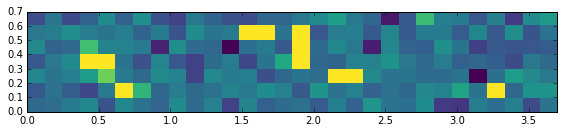

In [8]:
plotit(10**3 * 3600, 'viridis')

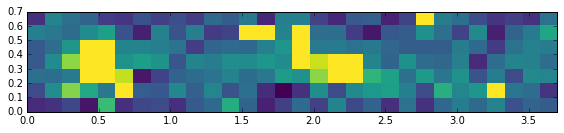

In [9]:
plotit(10**6 * 3600,'viridis')